In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py

import pandas as pd


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 30
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return m


In [3]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [4]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 10
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy


In [5]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

In [6]:
class TimeDistributedMultiHeadAttention(tf.keras.layers.Layer):
        def __init__(self, num_heads, key_dim, **kwargs):
            super().__init__(**kwargs)
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        def call(self, inputs):
            # Use tf.shape for dynamic shape and inputs.shape for static shape
            shape = tf.shape(inputs)
            static_shape = inputs.shape
            batch_size, num_subsequences, subsequence_length = shape[0], static_shape[1], static_shape[2]
            features = static_shape[3]

            reshaped_inputs = tf.reshape(inputs, [-1, subsequence_length, features])

            # Apply multi-head attention to each subsequence individually
            attention_output = self.multi_head_attention(reshaped_inputs, reshaped_inputs)

            # Reshape the output back to the original input shape
            output_shape = [-1, num_subsequences, subsequence_length, features]
            return tf.reshape(attention_output, output_shape)

        def compute_output_shape(self, input_shape):
            return input_shape
        
        def get_config(self):
            config = super().get_config()
            config.update({
                'num_heads': self.num_heads,
                'key_dim': self.key_dim
            })
            return config


In [7]:
import h5py
from matplotlib import pyplot as plt

f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/GW190521_background.hdf', 'r')
f2 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/GW190412_background.hdf', 'r')
f3 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/GW190602_background.hdf', 'r')
f4 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/GW190517_background.hdf', 'r')

GW190521_noise = f1['noise_samples']['l1_strain'][()]
GW190412_noise = f2['noise_samples']['l1_strain'][()]
GW190602_noise = f3['noise_samples']['l1_strain'][()]
GW190517_noise = f4['noise_samples']['l1_strain'][()]

GW190521_noise_signal = f1['noise_parameters']['l1_signal_whitened'][()]
GW190412_noise_signal = f2['noise_parameters']['l1_signal_whitened'][()]
GW190602_noise_signal = f3['noise_parameters']['l1_signal_whitened'][()]
GW190517_noise_signal = f4['noise_parameters']['l1_signal_whitened'][()]


In [8]:
f1.close()
f2.close()
f3.close()
f4.close()


In [9]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190521.hdf', 'r')
f2 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190412.hdf', 'r')
f3 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190602_175927.hdf', 'r')
f4 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190517_055101.hdf', 'r')

GW190521_strain = f1['GW190521-v3']['l1_strain'][()][None,:]
GW190412_strain = f2['GW190412-v3']['l1_strain'][()][None,:]
GW190602_strain = f3['GW190602_175927-v1']['l1_strain'][()][None,:]
GW190517_strain = f4['GW190517_055101-v1']['l1_strain'][()][None,:]

f1.close()
f2.close()
f3.close()
f4.close()

In [10]:
import os

def get_pe_data(event_name):
    
    # Define the base directory and file name
    base_dir = '/fred/oz016/Chayan/samplegen_old/output'
    file_name = event_name+'_maxl_li_signal_time_L1.dat'

    # Construct the full file path
    full_file_path = os.path.join(base_dir, file_name)
    
    with open(full_file_path, 'r') as file:
        time = []
        amp = []
        for line in file:
            # Split the line into parts based on whitespace or specific delimiter
            parts = line.split()  # Use split('\t') for tab-delimited files
        
            try:
                col1 = float(parts[0])
                col2 = float(parts[1])
                time.append(col1)
                amp.append(col2)
            except ValueError:
                print(f"Warning: Can't convert line to floats: {line.strip()}")

    time = np.array(time)
    amp = np.array(amp)

    return amp, time


def get_PE_reconst(reconst_cwb, gps_time, event_name):

    sampling_rate = 1024.0
    seconds_before_event = 0.8
    seconds_after_event = 0.2                                 
                                 
    pe_reconst, time = get_pe_data(event_name)   

    index_gps_time = np.where((time > gps_time-0.001) & (time < gps_time+0.001))[0][0]
    lower_lim = round(index_gps_time -(sampling_rate*seconds_before_event))
    upper_lim = round(index_gps_time +(sampling_rate*seconds_after_event))
     
    pe_reconst = pe_reconst[lower_lim:upper_lim][None,:]
    reconstructed_pe, maximum, minimum = _preprocess_data(pe_reconst,1,1024)
        
    if(event_name == 'GW190602_175927'):
        reconstructed_pe = reconstructed_pe[::2]

    return reconstructed_pe


cWB_file_path = os.path.join("/fred/oz016/Chayan/samplegen_old/output", "GW190521_rec_signal_time_L1.dat")
reconst_cWB = pd.read_csv(cWB_file_path, header=0, delimiter=" ")

GW190521_PE = get_PE_reconst(reconst_cWB, 1242442967.448, 'GW190521')[0]


In [11]:
cWB_file_path = os.path.join("/fred/oz016/Chayan/samplegen_old/output", "GW190412_rec_signal_time_L1.dat")
reconst_cWB = pd.read_csv(cWB_file_path, header=0, delimiter=" ")
GW190412_PE = get_PE_reconst(reconst_cWB, 1239082262.201, 'GW190412')[0]

cWB_file_path = os.path.join("/fred/oz016/Chayan/samplegen_old/output", "GW190602_175927_rec_signal_time_L1.dat")
reconst_cWB = pd.read_csv(cWB_file_path, header=0, delimiter=" ")
GW190602_PE = get_PE_reconst(reconst_cWB, 1243533585.085, 'GW190602_175927')[0]

cWB_file_path = os.path.join("/fred/oz016/Chayan/samplegen_old/output", "GW190517_055101_rec_signal_time_L1.dat")
reconst_cWB = pd.read_csv(cWB_file_path, header=0, delimiter=" ")
GW190517_PE = get_PE_reconst(reconst_cWB, 1242107479.820, 'GW190517_055101')[0]


In [12]:
strain = np.concatenate([GW190521_strain, GW190412_strain, GW190602_strain, GW190517_strain], axis=0)
noise = np.concatenate([GW190521_noise, GW190412_noise, GW190602_noise, GW190517_noise], axis=0)


In [13]:
strain, maximum, minimum = _preprocess_data(strain, strain.shape[0], 2048)
strain = np.array(strain)
strain.shape


(4, 2048)

In [14]:
noise, maximum_noise, minimum_noise = _preprocess_data(noise, noise.shape[0], 2048)
noise = np.array(noise)
noise.shape


(800, 2048)

In [15]:
X_test_strain = reshape_sequences(strain.shape[0], strain)
X_test_noise = reshape_sequences(noise.shape[0], noise)


In [16]:
# Reshape arrays to fit into Keras model
X_test_strain = X_test_strain[:,:,:,None]
print('x_test_strain shape:', X_test_strain.shape)
X_test_strain = X_test_strain.astype("float32")

X_test_noise = X_test_noise[:,:,:,None]
print('x_test_pure_signal shape:', X_test_noise.shape)
X_test_noise = X_test_noise.astype("float32")


x_test_strain shape: (4, 2058, 10, 1)
x_test_pure_signal shape: (800, 2058, 10, 1)


In [17]:
class NegativeLogLikelihood:
    def __call__(self, y, rv_y):
        return -rv_y.log_prob(y)

In [18]:
import tensorflow_probability as tfp

negloglik = NegativeLogLikelihood()

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_15_timesteps_uncertainty_amplitudes_scaled_100.h5', custom_objects={'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention, 'IndependentNormal': tfp.layers.IndependentNormal,'negloglik': negloglik})

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_DeepClean_10_timesteps_uncertainty_amplitudes_scaled_100_1.h5', custom_objects={'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention, 'IndependentNormal': tfp.layers.IndependentNormal,'negloglik': negloglik})


In [19]:
distribution = model(X_test_strain)
    
# Extract mean and standard deviation from the distribution
mean_preds = distribution.mean()
std_preds = distribution.stddev()
 
mean_preds = mean_preds.numpy().squeeze()
std_preds = std_preds.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound_90 = mean_preds - 1.645 * std_preds
upper_bound_90 = mean_preds + 1.645 * std_preds

lower_bound_50 = mean_preds - 0.6745 * std_preds
upper_bound_50 = mean_preds + 0.6745 * std_preds

In [20]:
distribution_noise = model(X_test_noise)
    
# Extract mean and standard deviation from the distribution
mean_preds_noise = distribution_noise.mean()
std_preds_noise = distribution_noise.stddev()
 
mean_preds_noise = mean_preds_noise.numpy().squeeze()
std_preds_noise = std_preds_noise.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound_90_noise = mean_preds_noise - 1.645 * std_preds_noise
upper_bound_90_noise = mean_preds_noise + 1.645 * std_preds_noise

lower_bound_50_noise = mean_preds_noise - 0.6745 * std_preds_noise
upper_bound_50_noise = mean_preds_noise + 0.6745 * std_preds_noise


In [21]:
mean_preds = mean_preds*100.0
mean_preds_noise = mean_preds_noise*100.0

In [22]:
std_preds = std_preds*100.0
std_preds_noise = std_preds_noise*100.0

In [23]:
from scipy.fft import fft, ifft

def get_snr_frac(decoded_signal):
    
    h_fft = fft(decoded_signal)
    template_fft = fft(decoded_signal)
    snr_freq = (h_fft * template_fft.conjugate())
    snr_time = np.abs(ifft(snr_freq))
    optimal_snr_ml = np.sqrt(np.max(snr_time))

    return optimal_snr_ml

In [24]:
original_strain = np.concatenate([GW190521_strain, GW190412_strain, GW190602_strain, GW190517_strain], axis=0)


In [26]:
mean_reconstructions, maximum, minimum = _preprocess_data(mean_reconstructions, mean_reconstructions.shape[0], 1024)
mean_reconstructions = np.array(mean_reconstructions)

In [25]:
residuals_signal = [(o-m[0:2048]) for o,m,s in zip(original_strain, mean_preds, std_preds)]

#residuals_signal_GW190521 = GW190521_PE-mean_reconstructions[0]

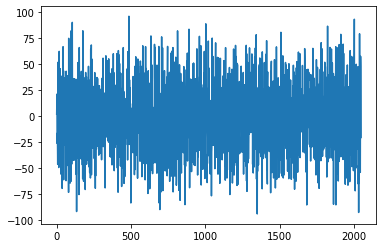

In [26]:
plt.plot(residuals_signal[0])

In [27]:
original_noise = np.concatenate([GW190521_noise, GW190412_noise, GW190602_noise, GW190517_noise], axis=0)


In [57]:
from pycbc.filter import sigma, sigmasq, matched_filter
from pycbc.types import TimeSeries

np.sqrt(sigmasq(TimeSeries((residuals_signal[0]).astype('float64'), delta_t = 1.0/2048), 
            psd=None,low_frequency_cutoff=30.0)/32.0)


7.944910151749634

In [51]:
from pycbc.catalog import Catalog

catalog = Catalog(source='gwtc-2')
    
events = ['GW190408_181802-v1']
    
psd = {}

strain = catalog['GW190408_181802-v1'].strain('H1')


In [55]:
strain.shape[0]/4096.0

32.0

In [56]:
np.sqrt(sigmasq(TimeSeries((mean_preds[0]).astype('float64'), delta_t = 1.0/2048), 
            psd=None,low_frequency_cutoff=30.0)/32.0)


2.1035000629919383

In [47]:
residuals_signal_GW190412 = GW190412_PE-mean_reconstructions[1]
residuals_signal_GW190602 = GW190602_PE-mean_reconstructions[2]
residuals_signal_GW190517 = GW190517_PE-mean_reconstructions[3]

In [48]:
from pycbc.filter import sigma, matched_filter
from pycbc.types import TimeSeries

snr_GW190521 = sigma(TimeSeries(residuals_signal_GW190521.astype('float64'), delta_t = 1.0/2048), 
            psd=None,low_frequency_cutoff=30.0) 

snr_GW190412 = sigma(TimeSeries(residuals_signal_GW190412.astype('float64'), delta_t = 1.0/2048), 
            psd=None,low_frequency_cutoff=30.0) 

snr_GW190602 = sigma(TimeSeries(residuals_signal_GW190602.astype('float64'), delta_t = 1.0/2048), 
            psd=None,low_frequency_cutoff=30.0) 

snr_GW190517 = sigma(TimeSeries(residuals_signal_GW190517.astype('float64'), delta_t = 1.0/2048), 
            psd=None,low_frequency_cutoff=30.0)             
                    

In [53]:
#original_noise = np.concatenate([GW190521_noise, GW190412_noise, GW190602_noise, GW190517_noise], axis=0)

#residuals_noise = [(o-m[0:2048]) for o,m,s in zip(original_noise, mean_preds_noise, std_preds_noise)]
#residuals_noise = np.array(residuals_noise)


In [54]:
#residuals_signal_snr = [get_snr_frac(signal) for signal in residuals_signal]


In [52]:
residuals_noise_snr = [sigma(TimeSeries(signal[0:2048], delta_t = 1.0/2048), psd=None,low_frequency_cutoff=30.0) 
                            for signal in mean_preds_noise.astype('float64')]


In [28]:
from pycbc.filter import sigma, matched_filter
from pycbc.types import TimeSeries

residuals_signal_snr = [matched_filter(TimeSeries(signal[0:2048], delta_t = 1.0/2048), TimeSeries(strain, delta_t = 1.0/2048),
                                        psd=None,low_frequency_cutoff=30.0) 
                            for signal, strain in zip(mean_preds.astype('float64'), residuals_signal.astype('float64'))]


In [29]:
snr_signals =  [max(abs(snr.numpy())) for snr in residuals_signal_snr]


In [30]:
snr_signals = np.array(snr_signals)

In [66]:
from scipy import stats

[stats.shapiro(signal) for signal in residuals_signal]

[ShapiroResult(statistic=0.9988593076192427, pvalue=0.20487234247861125),
 ShapiroResult(statistic=0.9985135625521379, pvalue=0.06701710023729192),
 ShapiroResult(statistic=0.9992322834469632, pvalue=0.5729094076674619),
 ShapiroResult(statistic=0.9992826632550192, pvalue=0.6393023524841621)]

In [35]:
residuals_noise_snr = [matched_filter(TimeSeries(signal[0:2048], delta_t = 1.0/2048), TimeSeries(strain, delta_t = 1.0/2048),
                                        psd=None,low_frequency_cutoff=30.0) 
                            for signal, strain in zip(mean_preds_noise.astype('float64'), residuals_noise.astype('float64'))]


In [37]:
snr_noise =  [max(abs(snr.numpy())) for snr in residuals_noise_snr]

snr_noise = np.array(snr_noise)


In [43]:
snr_signals

array([2.03821429, 1.29324408, 1.715343  , 3.30608058])